In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# import os

import keras 
# import keras_retinanet
import tensorflow as tf
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.models.resnet import resnet50_retinanet
from tensorflow.keras.models import load_model
from nms import retinanet_bbox
from sklearn.metrics import accuracy_score, precision_score
import keras
print(keras.__version__)
print


2.9.0


<function print>

In [2]:
##Carichiamo i dati dalla caltella

ruta_datos = 'C:/Users/fr4nc/OneDrive/Escritorio/DATOS_v1/bbx_520/bbx_520/'
#ruta_datos_val = 'C:/Users/fr4nc/OneDrive/Escritorio/DATOS_v1/bbx_520/bbx_520/'


In [3]:
## ruta degli Weights
#weights2= 'D:/angela/retinanet_resnet50_level_1.h5'
weights3= 'D:/angela/resnet101_oid_v1.0.0.h5'
#pretraided_model= load_model("C:/Users/fr4nc/OneDrive/Escritorio/cnn_4_clases_hotone.h5") 
#pesos= pretraided_model.load_weights('C:/Users/fr4nc/OneDrive/Escritorio/feature_extractor.h5', by_name=True, skip_mismatch=True)


In [4]:
##defino le trasformazioni che si applicarano ai dati.
transform_generator= random_transform_generator(min_rotation=-0.2,
                                                max_rotation=0.2,
                                                min_shear=-0.1,
                                                max_shear=0.1,
                                                min_scaling=(0.7, 0.7),
                                                max_scaling=(1.3, 1.3),
                                                flip_x_chance=0.5)

In [5]:
## costruimo i generatori di training e validazione

gen_train= CSVGenerator(ruta_datos+'labels_bbx_9000.csv',
                       ruta_datos+'clase.csv',
                       transform_generator=transform_generator)

gen_val= CSVGenerator(ruta_datos+'bbx_val.csv',
                       ruta_datos+'clase.csv',
                       shuffle_groups=False)


In [6]:
## Importiamo il modelo ad utilizare e la funzione per congelare il backbone
from keras.applications import resnet
#from keras_retinanet.models.resnet import resnet50_retinanet
from keras_retinanet.utils.model import freeze
from tensorflow.keras.applications import ResNet101


# If you want to load pretrained weights, uncomment the following line
# model.load_weights('path_to_pretrained_weights.h5', by_name=True, skip_mismatch=True)

backbone = ResNet101(include_top=False, input_shape=(None, None, 3), weights='imagenet')



In [7]:
modifier = freeze
model = resnet50_retinanet(num_classes=1)

In [8]:
##Cargamos los pesos del modelo

model.load_weights(weights3, by_name=True, skip_mismatch=True)
#model.load_weights('C:/Users/fr4nc/OneDrive/Escritorio/feature_extractor.h5' ,by_name=True, skip_mismatch=True)


In [9]:
##configuramos el entrenamiento, para ello cargamos la funcion de coste que utiliza
## la parte de la regresion y la clasificaicon del modelo

from keras_retinanet.losses import smooth_l1, focal

In [10]:
model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                       

In [11]:
## Compilamos el modelo utilzando optimizador adam con ratio de aprendizaje y el 
## clipnorm recoendados (1e-5 y 0.001)


model.compile(loss={'regression': smooth_l1(),
                    'classification':focal()
                   }, 
              optimizer =tf.optimizers.Adam(learning_rate=0.00001, clipnorm=2),
              metrics=['accuracy']
             )

In [12]:
hist= model.fit(
    gen_train,
    epochs = 150,
    steps_per_epoch = 400,
    validation_data= gen_val
)

Epoch 1/150
400/400 [==============================] - 252s 594ms/step - loss: 23.4130 - regression_loss: 0.8694 - classification_loss: 22.5436 - regression_accuracy: 0.3124 - classification_accuracy: 0.9977 - val_loss: 0.4697 - val_regression_loss: 0.3240 - val_classification_loss: 0.1457 - val_regression_accuracy: 0.3176 - val_classification_accuracy: 0.9985
Epoch 2/150
400/400 [==============================] - 250s 625ms/step - loss: 0.8155 - regression_loss: 0.5869 - classification_loss: 0.2287 - regression_accuracy: 0.2694 - classification_accuracy: 0.9983 - val_loss: 0.3874 - val_regression_loss: 0.3171 - val_classification_loss: 0.0704 - val_regression_accuracy: 0.2055 - val_classification_accuracy: 0.9985
Epoch 3/150
400/400 [==============================] - 253s 634ms/step - loss: 0.6714 - regression_loss: 0.5022 - classification_loss: 0.1692 - regression_accuracy: 0.2725 - classification_accuracy: 0.9984 - val_loss: 0.3362 - val_regression_loss: 0.2667 - val_classification_

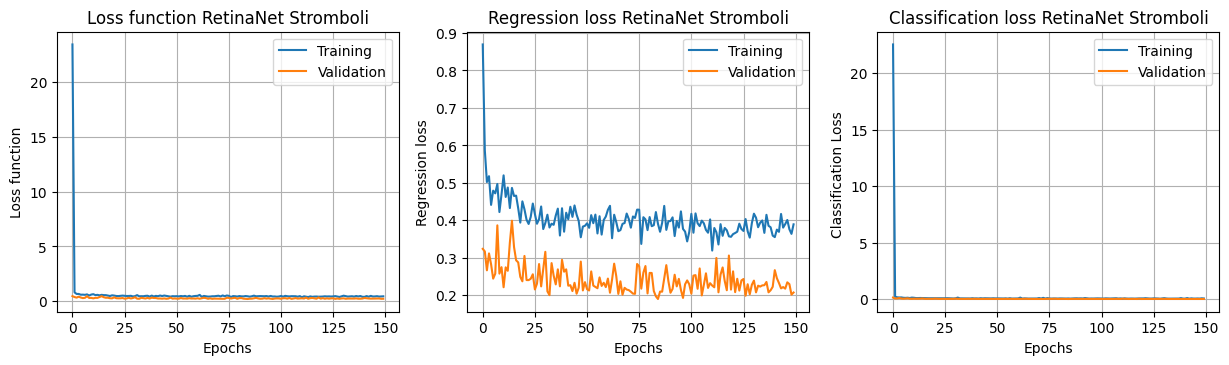

In [13]:
##30 epch 110 stpvaldation
plt.figure(figsize=(15,8))

plt.subplot(231)
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss function')

plt.title("Loss function RetinaNet Stromboli")
plt.legend()
plt.grid()

plt.subplot(232)
plt.plot(hist.history['regression_loss'], label='Training')
plt.plot(hist.history['val_regression_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Regression loss')
plt.title("Regression loss RetinaNet Stromboli")
plt.legend()
plt.grid()

plt.subplot(233)
plt.plot(hist.history['classification_loss'], label='Training')
plt.plot(hist.history['val_classification_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Classification Loss ')
plt.title("Classification loss RetinaNet Stromboli")
plt.legend()
plt.grid()

In [14]:
from keras_retinanet.models import convert_model
model_bbx= convert_model(model)
model_bbx_thr=retinanet_bbox(model, nms_threshold= 0.25)

In [15]:
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

1/1 [==============================] - 1s 1s/step
0.94173265 0
0.9375565 0


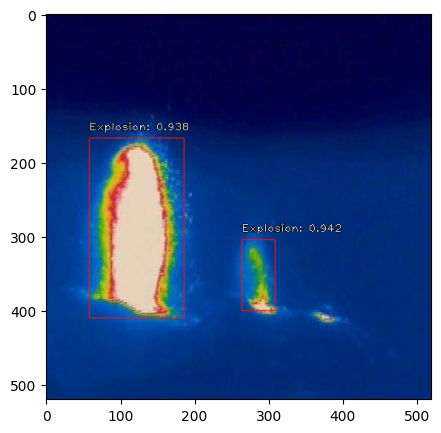

In [16]:
from keras_retinanet.utils.image import preprocess_image, resize_image, read_image_bgr
from PIL import Image
import cv2 as cv

img= read_image_bgr('C:Users/fr4nc/OneDrive/Escritorio/nord-suud/194-20230920-01513700.jpg')
#img= read_image_bgr('C:/Users/fr4nc/OneDrive/Escritorio/nord-suud/538-20230915-11092900.jpg')
#img= read_image_bgr('D:/CameraViewer/frame/0731/SPT_20230731_A/SPT_20230731/SPT_20230731-000000/440-20230731-00035000.jpg')
#img= img[0:520, 0:704]
draw= img.copy()
draw= cv.cvtColor(draw, cv.COLOR_BGR2RGB)
img= preprocess_image(img)
img, scale = resize_image(img)
img = np.expand_dims(img, axis=0)
boxes, scores, labels = model_bbx.predict(img)

boxes /= scale
## guardiamo le detections

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.20:
        break
    color = label_color(label*13+3)
    b= box.astype(label)
    draw_box(draw,b,color=color,thickness=1 )
    nort_Explostion= label==0
    south_Explosion= label==1
    if nort_Explostion== True:
        caption= "{}{:.3f}".format('Explosion: ',score)
    elif south_Explosion== True:
        caption= "{}{:.3f}".format('Explosion: ',score)
    draw_caption(draw,b,caption)
    print(score,label)
plt.figure(figsize=(5,5))
plt.imshow(draw)
#0.996 y 0.912

1/1 [==============================] - 1s 1s/step
0.94173265 0
0.9375565 0


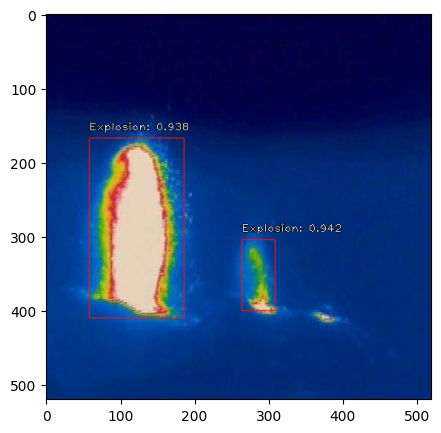

In [17]:
from keras_retinanet.utils.image import preprocess_image, resize_image, read_image_bgr
from PIL import Image
import cv2 as cv

img= read_image_bgr('C:Users/fr4nc/OneDrive/Escritorio/nord-suud/194-20230920-01513700.jpg')
#img= read_image_bgr('C:/Users/fr4nc/OneDrive/Escritorio/nord-suud/538-20230915-11092900.jpg')
#img= read_image_bgr('D:/CameraViewer/frame/0731/SPT_20230731_A/SPT_20230731/SPT_20230731-000000/440-20230731-00035000.jpg')
#img= img[0:520, 0:704]
draw= img.copy()
draw= cv.cvtColor(draw, cv.COLOR_BGR2RGB)
img= preprocess_image(img)
img, scale = resize_image(img)
img = np.expand_dims(img, axis=0)
boxes, scores, labels = model_bbx_thr.predict(img)

boxes /= scale
## guardiamo le detections

for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < 0.35:
        break
    color = label_color(label*13+3)
    b= box.astype(label)
    draw_box(draw,b,color=color,thickness=1 )
    nort_Explostion= label==0
    south_Explosion= label==1
    if nort_Explostion== True:
        caption= "{}{:.3f}".format('Explosion: ',score)
    elif south_Explosion== True:
        caption= "{}{:.3f}".format('Explosion: ',score)
    draw_caption(draw,b,caption)
    print(score,label)
plt.figure(figsize=(5,5))
plt.imshow(draw)
#0.809 y 0.681

In [18]:
from tensorflow.keras.models import save_model

# model_bbx.save("C:/Users/fr4nc/OneDrive/Escritorio/detect_explosion_11mil_validation.h5")
model_bbx_thr.save("C:/Users/fr4nc/OneDrive/Escritorio/detect_explosion_threshold_validation_color.h5")


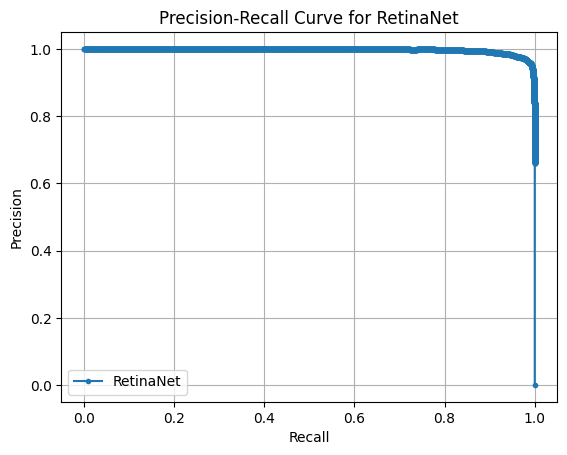

In [19]:
from keras_retinanet.utils.eval import evaluate

import numpy as np
import matplotlib.pyplot as plt
from keras_retinanet.utils.image import preprocess_image, resize_image
from sklearn.metrics import precision_recall_curve

# Initialize lists to store results
all_scores = []
all_true_positives = []
all_false_positives = []

# Function to calculate IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

# Helper function to compute true positives, false positives, and false negatives
def compute_tp_fp_fn(annotations, boxes, scores, iou_threshold):
    tp = []
    fp = []
    scores_filtered = []
    
    # Keep track of matched annotations
    matched_annotations = np.zeros(len(annotations['bboxes']), dtype=bool)
    
    # For each predicted box
    for score, box in zip(scores[0], boxes[0]):
        max_iou = 0
        matched_idx = -1
        for idx, annotation in enumerate(annotations['bboxes']):
            if matched_annotations[idx]:
                continue  # Skip already matched annotations
            iou = compute_iou(box, annotation)
            if iou > max_iou:
                max_iou = iou
                matched_idx = idx
        
        # Classify as TP if IoU exceeds threshold, otherwise FP
        if max_iou >= iou_threshold and matched_idx != -1:
            tp.append(1)
            fp.append(0)
            matched_annotations[matched_idx] = True  # Mark annotation as matched
        else:
            tp.append(0)
            fp.append(1)
        
        scores_filtered.append(score)
    
    # Any remaining unmatched annotations are considered false negatives (FN)
    
    return tp, fp, scores_filtered

# Loop over the validation data
for i in range(len(gen_val)):
    # Load image and annotations
    image = gen_val.load_image(i)
    annotations = gen_val.load_annotations(i)

    # Preprocess the image and make predictions
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model_bbx_thr.predict_on_batch(np.expand_dims(image, axis=0))

    # Rescale boxes back to original image dimensions
    boxes /= scale

    # Compute true positives, false positives, and filter the scores
    tp, fp, scores_filtered = compute_tp_fp_fn(annotations, boxes, scores, iou_threshold=0.6)
    
    # Append the results for precision-recall calculation
    all_true_positives.extend(tp)
    all_false_positives.extend(fp)
    all_scores.extend(scores_filtered)

# Now calculate precision and recall using sklearn's precision_recall_curve
precision, recall, _ = precision_recall_curve(all_true_positives, all_scores)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, marker='.', label='RetinaNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RetinaNet')
plt.legend()
plt.grid(True)
plt.show()




In [20]:
ap= evaluate(gen_val,
             model_bbx_thr,
             score_threshold=0.1,
             iou_threshold=0.6)

print("The Average Precision (AP) of Iou 0.6 is: ", ap)
print("Averge Precision(AP) is:", format(100*( ap[0][0][0]),'.2f'),"%")

Running network:   0% (0 of 6838) |      | Elapsed Time: 0:00:00 ETA:  --:--:--
Running network:   0% (3 of 6838) |      | Elapsed Time: 0:00:00 ETA:   0:05:34
Running network:   0% (6 of 6838) |      | Elapsed Time: 0:00:00 ETA:   0:05:32
Running network:   0% (9 of 6838) |      | Elapsed Time: 0:00:00 ETA:   0:05:32
Running network:   0% (12 of 6838) |     | Elapsed Time: 0:00:00 ETA:   0:05:31
Running network:   0% (15 of 6838) |     | Elapsed Time: 0:00:00 ETA:   0:05:31
Running network:   0% (18 of 6838) |     | Elapsed Time: 0:00:00 ETA:   0:05:31
Running network:   0% (20 of 6838) |     | Elapsed Time: 0:00:00 ETA:   0:05:36
Running network:   0% (23 of 6838) |     | Elapsed Time: 0:00:01 ETA:   0:05:36
Running network:   0% (26 of 6838) |     | Elapsed Time: 0:00:01 ETA:   0:05:36
Running network:   0% (29 of 6838) |     | Elapsed Time: 0:00:01 ETA:   0:05:35
Running network:   0% (32 of 6838) |     | Elapsed Time: 0:00:01 ETA:   0:05:34
Running network:   0% (35 of 6838) |    

The Average Precision (AP) of Iou 0.6 is:  ({0: (0.9744778583415796, 2410.0)}, 0.036252538897761755)
Averge Precision(AP) is: 97.45 %


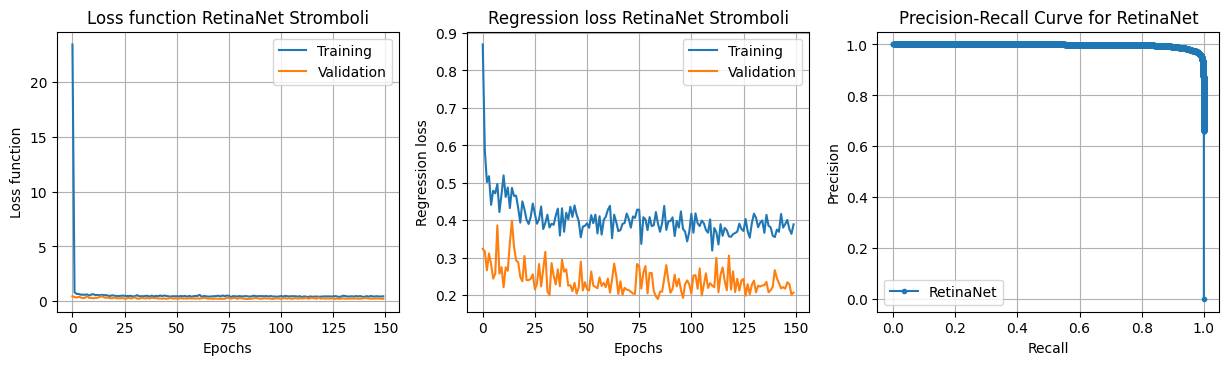

In [21]:
plt.figure(figsize=(15,8))

plt.subplot(231)
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss function')

plt.title("Loss function RetinaNet Stromboli")
plt.legend()
plt.grid()

plt.subplot(232)
plt.plot(hist.history['regression_loss'], label='Training')
plt.plot(hist.history['val_regression_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Regression loss')
plt.title("Regression loss RetinaNet Stromboli")
plt.legend()
plt.grid()

plt.subplot(233)
plt.plot(recall, precision, marker='.', label='RetinaNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RetinaNet')
plt.legend()
plt.grid()